In [1]:
import glob

from functools import lru_cache

import numpy             as np
import matplotlib.pyplot as plt

from CCfun  import in_range
from CCfun  import filter_df
from CCfun  import longer_than_exwl
from CCfun  import find_crystal_position
from CCfun  import compute_baseline_between

from CCfit import fit
from CCfit import shifted_gauss
from CCfit import gauss
from CCfit import shifted_double_gauss

from CCplot import plot_line
from CCplot import figure_sizes
from CCplot import subplots
from CCplot import auto_plot_style

from CCdatabase import californication_irradiation_mapping
from CCdatabase import position_correction

from CCio import load_all

In [2]:
load_all  = lru_cache()(load_all)

In [3]:
%matplotlib inline

auto_plot_style()

In [4]:
fit_peaks  = {"CaF600": (770,),
              "CaF410": (580,),
              "CaF400": (770,),
              "CaF350": (630,),
             }

fit_ranges = {"CaF600": ((600, 1000),),
              "CaF410": ((380,  780),),
              "CaF400": ((570, 1000),),
              "CaF350": ((630,    ),),
             }

fit_models = {"CaF600": (gauss,),
              "CaF410": (gauss,),
              "CaF400": (gauss,),
              "CaF350": (gauss,),
             }

fit_seeds  = {"CaF600": ((1e-12, fit_peaks["CaF600"][0], 30),),
              "CaF410": ((1e-12, fit_peaks["CaF410"][0], 30),),
              "CaF400": ((1e-12, fit_peaks["CaF400"][0], 30),),
              "CaF350": ((1e-12, fit_peaks["CaF350"][0], 30),),
             }

baseline_ranges = {"CaF600": (1000, 1010),
                   "CaF410": (1110, 1120),
                   "CaF400": (1100, 1110),
                   "CaF350": (1050, 1060),
                  }

ratios = [("CaF_B1_282", "CaF_B1_281"), ("CaF_B1_282", "CaF_B1_289"), ("CaF_B1_282", "CaF_B1_290"),
          ("CaF_B1_282", "CaF_B1_292"), ("CaF_B1_290", "CaF_B1_292"), ("CaF_B1_289", "CaF_B1_292")]

expected_ratios = [      1.07, 2.3 * 0.94, 3.51,
                   2.3 * 3.23, 2.3 * 0.97, 3.7 ]

In [14]:
def do_fit(x, y, key, *args, **kwargs):
    f    = fit(fit_models[key][0]         ,
               x, y, fit_seeds[key][0]    ,
               *args, **kwargs            ,
               fit_range = fit_ranges[key][0],
               maxfev    = int(1e5)       )
    return f


def fit_crystal(df, metadata, plot=False, **plotargs):
    try:
        assert len(df) == 1600
    except:
        print(df.exposure  .drop_duplicates())
        print(df.exp_index .drop_duplicates())
        print(df.looparound.drop_duplicates())
        print(df.state     .drop_duplicates())
        print(df.crystal   .drop_duplicates())
        print(df.crystal_id.drop_duplicates())
        raise

    crystal_id   = df.crystal_id  .values[0]
    crystal_type = df.crystal_type.values[0]
    ex_wl        = df.ex_wl       .values[0]
    key  = f"{crystal_type}{int(ex_wl)}"

    df   = longer_than_exwl(df)
    x, y = df.em_wl.values, df.dquanta.values
    y    = y - compute_baseline_between(x, y, *baseline_ranges[key])
    y    = y * position_correction(find_crystal_position(crystal_id, metadata))
    f    = do_fit(x, y, key)
    if plot:
        if "spectrum" in plot: plt.plot(x, y      , "." , label="data", **plotargs)
        if "fit"      in plot: plt.plot(x, f.fn(x), "--", label="fit" , **plotargs)
        print(f.values)
        
    return f.values[0] / np.diff(x)[0], f.errors[0] / np.diff(x)[0]


def get_integrals_different_exposures(df, metadata):
    integrals, errors = [], []
    for _, data in sorted(df.groupby("state")):
        integral, error = fit_crystal(data, metadata)
        integrals.append(integral)
        errors   .append(error   )
    return np.array(integrals), np.array(errors)


def get_integrals_different_scans(df, metadata):    
    integrals, errors = {}, {}
    for loop, data in sorted(df.groupby("looparound")):
        scan = "looparound" if loop else "main scan"
        ints, errs = get_integrals_different_exposures(data, metadata)
        integrals[scan] = ints
        errors   [scan] = errs
    return integrals, errors


def get_integrals_different_crystals(df, metadata):
    integrals, errors = {}, {}
    for crystal, data in sorted(df.groupby("crystal_id")):
        ints, errs = get_integrals_different_scans(data, metadata)
        integrals[crystal] = ints
        integrals[crystal] = errs
    return integrals, errors

In [6]:
filenames_pre  = tuple(glob.glob("/home/gonzalo/data/CC/Californication/*pre*.h5" ))
filenames_post = tuple(glob.glob("/home/gonzalo/data/CC/Californication/*post*.h5"))
experiment     = load_all(filenames_pre, filenames_post)

In [7]:
caf600_pre  = filter_df(experiment.pre .crystals, crystal_type="CaF", ex_wl=600, grating=2)
caf600_post = filter_df(experiment.post.crystals, crystal_type="CaF", ex_wl=600, grating=2)

[2.24482869e-10 7.57122920e+02 4.65307221e+01]
[5.10535814e-10 7.57154906e+02 4.66886092e+01]


Text(0, 0.5, '# em / # ex')

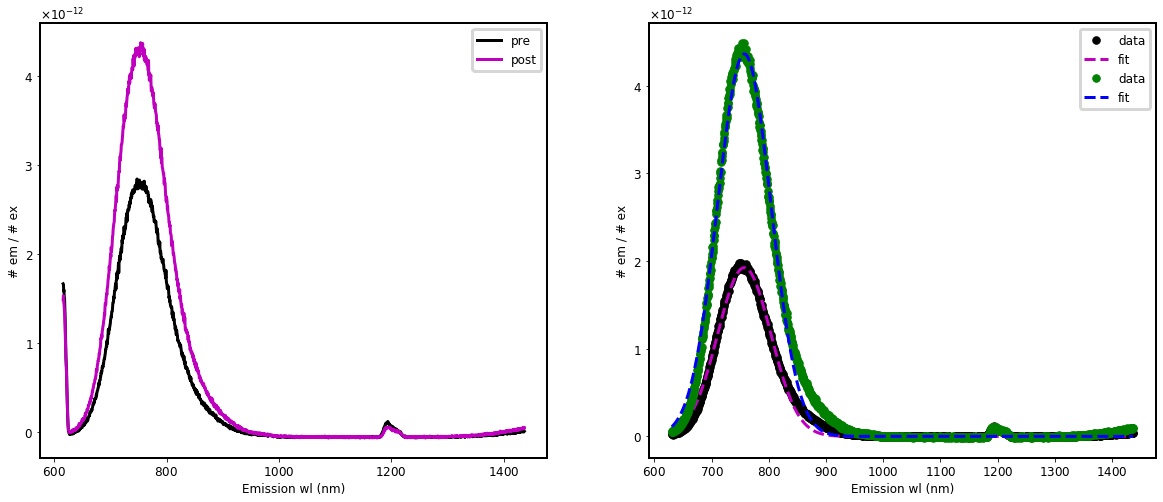

In [15]:
df_pre  = filter_df(experiment.pre .crystals, crystal_id="CaF_B1_282", ex_wl=600, grating=2, exposure=1, exp_index=0, looparound=True )
df_post = filter_df(experiment.post.crystals, crystal_id="CaF_B1_282", ex_wl=600, grating=2, exposure=1, exp_index=0, looparound=False)

assert len(df_pre) == len(df_post) == 1600

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(df_pre .em_wl, df_pre .dquanta, "k", label="pre" )
plt.plot(df_post.em_wl, df_post.dquanta, "m", label="post")

plt.legend()
plt.xlabel("Emission wl (nm)")
plt.ylabel("# em / # ex")

plt.subplot(1, 2, 2)
fit_crystal(df_pre , experiment.pre .metadata, plot="spectrumfit")
fit_crystal(df_post, experiment.post.metadata, plot="spectrumfit")

plt.legend()
plt.xlabel("Emission wl (nm)")
plt.ylabel("# em / # ex")


In [16]:
ints_pre , errs_pre  = get_integrals_different_crystals(caf600_pre , experiment.pre .metadata)
ints_post, errs_post = get_integrals_different_crystals(caf600_post, experiment.post.metadata)

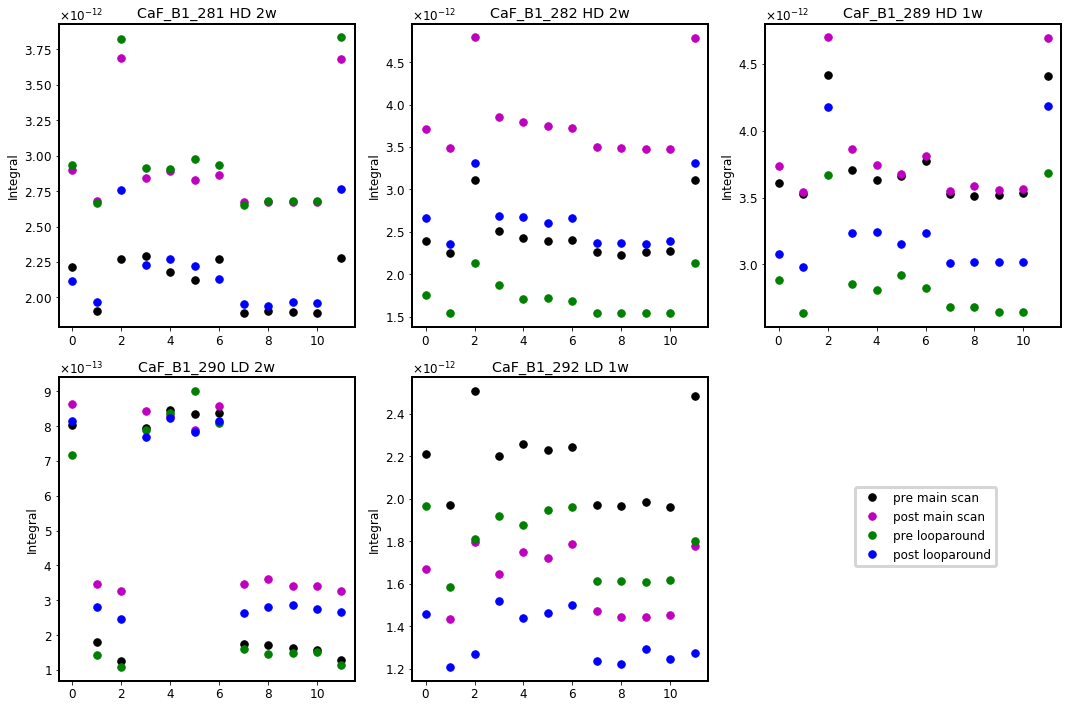

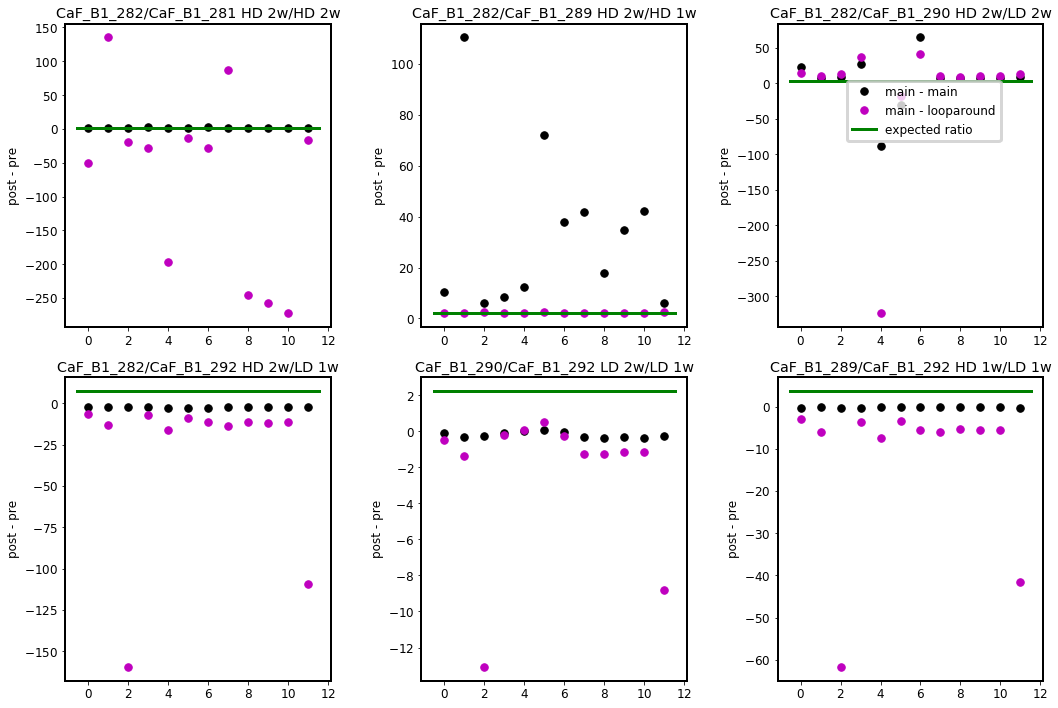

In [18]:
def plot_integrals(ints_pre, ints_post):
    plt.figure(figsize=figure_sizes[6])
    plots = []
    for k, (crystal, pres) in enumerate(sorted(ints_pre.items()), start=1):
        plt.subplot(*subplots[6], k)
        for scan, pre in sorted(pres.items(), reverse=True):
            post = ints_post[crystal][scan]
            plots.append(plt.plot(np.arange(12), pre , ".", label="pre  " + scan)[0])
            plots.append(plt.plot(np.arange(12), post, ".", label="post " + scan)[0])
        
        plt.ylabel("Integral")
        plt.title (crystal + " " + californication_irradiation_mapping[crystal])
    plt.figlegend(plots[-4:], ("pre main scan", "post main scan", "pre looparound", "post looparound"), loc=(0.8, 0.2))
    plt.tight_layout()
    
def plot_diffs(ints_pre, ints_post):
    plt.figure(figsize=figure_sizes[6])
    plots = []
    for k, (crystal, pres) in enumerate(sorted(ints_pre.items()), start=1):
        posts = ints_post[crystal]
        
        plt.subplot(*subplots[6], k)
        a = plt.plot(np.arange(12), posts["main scan"] - pres["main scan" ], ".")
        b = plt.plot(np.arange(12), posts["main scan"] - pres["looparound"], ".")
        
        plt.ylabel("post - pre")
        plt.title (crystal + " " + californication_irradiation_mapping[crystal])
    plt.figlegend((a[0], b[0]), ("main - main", "main - looparound"), loc=(0.8, 0.2))
    plt.tight_layout()

def plot_ratios(ints_pre, ints_post):
    plt.figure(figsize=figure_sizes[6])
    plots = []
    
    for k in range(6):
        plt.subplot(*subplots[6], k + 1)
        
        top, bot = ratios[k]
        
        diff_top = ints_post[top]["main scan"] - ints_pre[top]["main scan" ]
        diff_bot = ints_post[bot]["main scan"] - ints_pre[bot]["main scan" ]
        ratio_mm = diff_top / diff_bot
        
        diff_top = ints_post[top]["main scan"] - ints_pre[top]["looparound"]
        diff_bot = ints_post[bot]["main scan"] - ints_pre[bot]["looparound"]
        ratio_ml = diff_top / diff_bot
        
        
        a = plt.plot(np.arange(12), ratio_mm, ".")
        b = plt.plot(np.arange(12), ratio_ml, ".")
        c = plot_line(expected_ratios[k], axis="x")
        
        plt.ylabel("post - pre")
        #plt.ylim(-2, 10)
        plt.title (top + "/" + bot + " " + californication_irradiation_mapping[top] + "/" + californication_irradiation_mapping[bot])
    plt.figlegend((a[0], b[0], c[0]), ("main - main", "main - looparound", "expected ratio"), loc=(0.8, 0.8))
    plt.tight_layout()
    

plot_integrals(ints_pre, ints_post)
plot_diffs    (ints_pre, ints_post)
plot_ratios   (ints_pre, ints_post)